### This file simulates the results of the structural model.
#### It shows the cross-section distribution of firms' outcomes.

#### By Phil Huang.

In [1]:
import pandas as pd
import numpy as np
import random
import copy
from matplotlib import pyplot as plt 
from copulas.datasets import sample_trivariate_xyz
from copulas.visualization import scatter_3d, compare_3d
from copulas.multivariate import GaussianMultivariate
from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate
from scipy.stats import pareto, beta
from fitter import Fitter, get_common_distributions, get_distributions
from datetime import datetime
%matplotlib inline

In [2]:
# specify the path
path  = '/Users/philhuang/Desktop/FDI/workingdata/'
figure_path = '/Users/philhuang/Desktop/FDI/figure/'

### Load in some functions we need to use for solving for optimal $\eta$ and $\delta$.

In [3]:
# Eqaution 8 where we calculate optimal beta.
def get_optimal_beta(sigma, eta):
    part1     = eta/(1-eta)
    part2     = 1-(sigma-1)*(1-eta)/sigma 
    part3     = 1- (sigma-1)*eta/sigma 
    temp      = np.sqrt(part1*part2/part3)
    beta_star = temp/(1+temp)
    return beta_star

# From (8), we solve for eta given beta. We need to use binary search.
# First, we define a function with which we get the value which is closer to the target.
# when we have two candidates RHS_vals[a]<RHS_vals[b], which means the a_th RHS value smaller than the target 
# and the b_th RHS values bigger than the target.

def get_closer_num(lst,a,b,target):
    baseline = abs(lst[a]-target)
    if abs(lst[b]-target) <= baseline:
        return b
    else:
        return a

# Then we define a binary search function to solve the function.
# In general, lst_a contains the target we want to search for, and we want to return the corresponding 
# element in lst_b
def get_ans(lst_a, lst_b, target):
    
    left=0 
    right=len(lst_a)
    
    while left<right:
        middle = left+ ((right - left)//2)
        if lst_a[middle] == target:
            return lst_b[middle]
        if lst_a[middle] < target:
            if lst_a[middle+1] >= target:
                idx_g = get_closer_num(lst_a, middle, middle+1, target)
                return lst_b[idx_g]
            else:
                left = middle+1
        if lst_a[middle] > target:
            if lst_a[middle-1] <= target:
                idx_g = get_closer_num(lst_a, middle-1, middle, target)
                return lst_b[idx_g]
            else:
                right = middle

# Equation 7. Given sigma, eta and beta, we get delta. 
# Note that since beta* is a function of sigma and eta, delta is a function of sigma and eta too. 
def get_delta(sigma, eta, beta):
    part1 = sigma - (sigma-1)*(beta*eta+(1-beta)*(1-eta))
    part2 = (((1/beta)**eta) * ((1/(1-beta))**(1-eta)))**(1-sigma)
    delta = part1*part2
    return delta

# define a function to calculate omega used in the counterfactuals.
def get_Omega(sigma, eta, beta):
    part1 = (1/beta)**eta
    part2 = (1/(1-beta))**(1-eta)
    Omega = (part1*part2)**(1-sigma)
    return Omega

# Input equation (15-19)
def get_FirmVar(beta, eta, sigma, wh, wm, tau, varphi, P, X, bunch_or_not, cost):
    
    p_star  = (sigma/(sigma-1))* ((wh/eta)**eta) * ((wm/(1-eta))**(1-eta)) /varphi
    p_tild  = (sigma/(sigma-1)) * (wh/(beta*eta))**eta * (wm/((1-beta)*(1-eta)))**(1-eta) / varphi
    x_tild  = p_tild**(1-sigma) * P**(sigma-1) * X * (1-tau)**sigma
    h_tild  = ((sigma-1)/sigma) * (beta*eta/wh) * x_tild
    m_tild  = ((sigma-1)/sigma) * ((1-beta)*(1-eta)/wm) * x_tild
    
    # Note that if ther is no bunching (bunch_or_not == 1), the final Pi is just Pi_tild.
    # If there is bunching (bunch_or_not == 0), then the final Pi should deduct the cost.
    pi_tild = (get_delta(sigma, eta, beta)-cost*(1-bunch_or_not))* p_star**(1-sigma) * P**(sigma-1)* X*((1-tau)**sigma)/sigma

    return p_tild, x_tild, h_tild, m_tild, pi_tild
    #return pi_tild


### P1. Generate distribution of intensity and productivity we need.

In [4]:
# We read in bins (beta), eta data and see their distributions. 
beta_eta_df   = pd.read_csv(path+'beta_eta.csv')
beta_all      = np.array(beta_eta_df['beta_bins'])
eta_all       = np.array(beta_eta_df['eta_bins'])

# Read in bins, real distribution and counterfactual distributions of firms we use in the bunching estimation.
bunching_df   = pd.read_excel(path+'R2_pre2008June122023.xlsx')
bunching_df

bins_bunching = np.array(bunching_df['R2_bins'])
C_bunching    = np.array(bunching_df['R2_C_all'])  # Actual probability of firms falling into each bins.
h_bunching    = np.array(bunching_df['h'])         # Counterfactual probability of firms falling into each bins.

bunching_para = pd.read_excel(path+'R4_pre2008June122023.xlsx')
p             = np.int32(np.array(bunching_para['p'])[0])                                 # Polynomial.
minD          = np.float64(np.array(bunching_para['minD'])[0])                             # Minimum of the bins we use.

tau_L         = np.float64(0.15)
tau_H         = np.float64(0.225)
notch         = np.float64(0.25)
Reps          = 1

w_h           = 1
w_m           = 1
big_p         = 1
big_x         = 1

# Read in the parameters we calibrated.
final_paras = pd.read_csv(path+'calibration_rstJune122023.csv')
sigma, theta, k, mu_c = np.array(final_paras)[0,:]
print(sigma, theta, k, mu_c)

# Read in b that we estimated from the bunching part.
b = np.array(pd.read_excel(path+'R5_pre2008June122023.xlsx')['b'])


2.346160352519226 20.05298080521329 2.151907030827452 0.3203391475285694


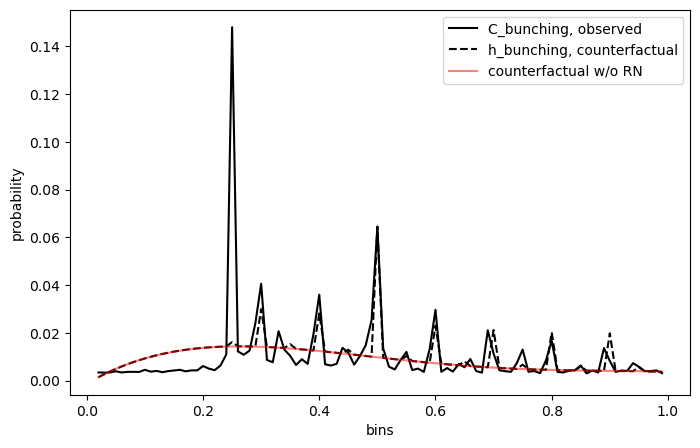

In [5]:
# Now we want to get the distribution of eta. 
# In order to do so, we omit all the round number effects. 
polynomial_beta = []
for i in range(p+1):
    polynomial_beta.append(bins_bunching**i)
polynomial_beta = np.array(polynomial_beta).T

# Multiply b and polynomial_beta together.
distribution_noRN = np.dot(polynomial_beta, b[:p+1].reshape(p+1,-1))
distribution_noRN = distribution_noRN.ravel()

# Plot the distribution.
fig1, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.plot(bins_bunching, C_bunching, linestyle='solid', c='k', linewidth=1.5, label='C_bunching, observed')
ax.plot(bins_bunching, h_bunching, linestyle='--', c='k', linewidth=1.5, label='h_bunching, counterfactual')
ax.plot(bins_bunching, distribution_noRN, linestyle='solid', alpha=0.5, c='r', 
        linewidth=1.5, label='counterfactual w/o RN')
ax.set(xlabel='bins', ylabel='probability')
ax.legend()

In [6]:
# Now we simulate 100,000 firms. 
# The first step is to generate 100,000 betas according to the counterfactual distribution of Beta.
# Now we know the probability of etas falling into each bins, we simulate data of eta based on this.
# cf means counterfactual here.
beta_cf_simul = []
# We cut the last bin (0.99-1) out since there would be a lot of extrem values in that bin when we calculate eta.
bins_bunching = np.array(bunching_df['R2_bins'])

# We get lower and uppper bond of each bin, and sample beta within each bin.
beta_temp  = list(bins_bunching)
beta_temp.append(np.float64(1.0))
total_firm_num = 100000

for i in range(len(beta_temp)-1):
    lb_bin  = beta_temp[i]     # lower bond of the bin
    ub_bin  = beta_temp[i+1]   # upper bond of the bin 
    len_bin = ub_bin-lb_bin
    
    # Number of firms in each bin, each should have an eta that lies within the range of the bin. 
    # Here we assume that in each bin, eta is uniformly distributed.
    bin_firm_num = int(h_bunching[i]*total_firm_num)
    np.random.seed(123+i)
    
    # Random.random_sample generates uniformly-distributed sample in [0,1). So here we need to multiply them
    # by the length of each bin, and add lb_bin to it. 
    rand_uniform   = np.random.random_sample(size = bin_firm_num)
    beta_each_bin  = list(rand_uniform*len_bin + lb_bin)
    beta_cf_simul += beta_each_bin

Number of simulated firms: 99277
Number of counterfactual firms: 99321
Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.
There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.


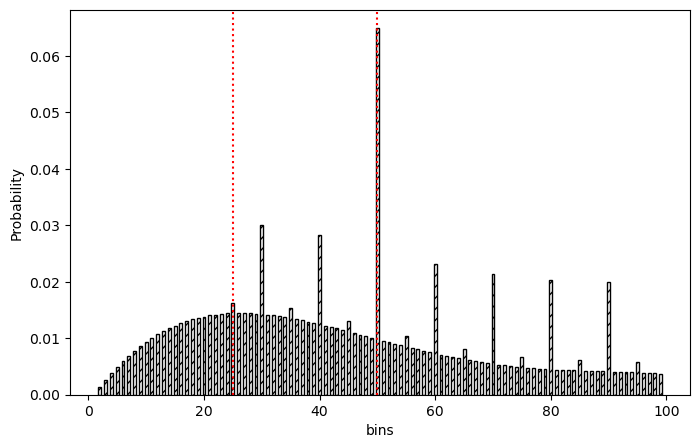

In [7]:
# Let's check how our simulated beta looks like. 
a1 = len(beta_cf_simul)
a2 = int(np.sum(h_bunching)*total_firm_num)
print('Number of simulated firms: {0}'.format(a1))
print('Number of counterfactual firms: {0}'.format(a2))
print('Note that there should be less than 100,000 firms since we exclude firms with fdi_share>0.99, and fdi_share less than 0.02.')
print('There is some slight difference between the number of counterfactual and simulated firms because we round the floats to integers.')
# Now we put all the simulated_beta_star into each bins.
bins_temp = np.arange(2,100)/100

# Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
simul_bin_id = np.digitize(beta_cf_simul, bins_temp, right=False)
simul_bin_id = simul_bin_id+1

# Count how many betas are there in each bin.
simul_beta_df      = pd.DataFrame(data={'beta_cf_simul':np.array(beta_cf_simul), 'simul_bin_id':np.array(simul_bin_id)})
simul_betaCount_df = simul_beta_df.groupby('simul_bin_id')['beta_cf_simul'].count()
simul_betaCount_df = simul_betaCount_df.reset_index()
simul_betaCount_df.rename(columns={'beta_cf_simul':'count'}, inplace=True)

# Plot the distribution. 
# Label the 25% and 50% bins.
fig2, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
ax.bar(simul_betaCount_df['simul_bin_id'], simul_betaCount_df['count']/a1, edgecolor='black', facecolor='white', hatch='///', width=0.5)
ax.set(xlabel='bins', ylabel='Probability')
ax.axvline(x=25, c='r', linestyle=':')
ax.axvline(x=50, c='r', linestyle=':')



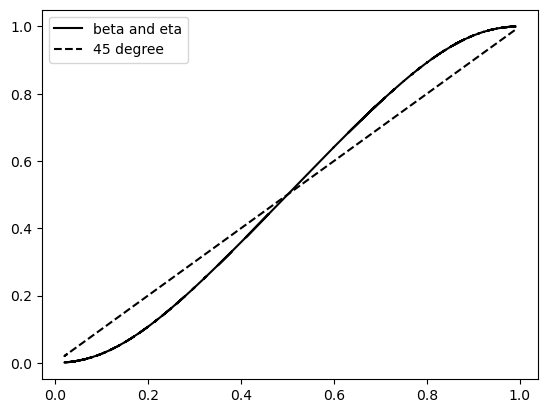

In [8]:
# Now we calculate optimal eta for these firms.
# With beta_bins, calculate the LHS of (8). This is the list of targets we are searching for. 
# Note that now when beta>0.99, there would be extreme values when we calculate eta. For simplicity, we replace
# all beta>0.99 to be 0.99.
simul_beta_df.loc[simul_beta_df['beta_cf_simul']>0.99, ['beta_cf_simul']]=0.99
beta_cf_simul = simul_beta_df['beta_cf_simul'].values
LHS_8 = np.array(beta_cf_simul)/(1-np.array(beta_cf_simul))

# Define the space of eta, which is the lst_b in the get_ans function. 
eta_space = np.linspace(0.0001, 0.9999, 1000000)

# Calculate the RHS of equation 8, which is the lst_a in the get_ans function. 
part1  = eta_space/(1-eta_space)
part2  = 1-(sigma-1)*(1-eta_space)/sigma 
part3  = 1- (sigma-1)*eta_space/sigma 
RHS_8  = np.sqrt(part1*part2/part3)

eta_simul = np.zeros(len(beta_cf_simul))

for i in range(len(beta_cf_simul)): 
    eta_simul[i] = get_ans(RHS_8, eta_space, LHS_8[i])

simul_beta_df['eta_simul'] = np.array(eta_simul)

# Let's see the relationship between beta and eta.
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['eta_simul'], c='k', linestyle='-', label='beta and eta')
plt.plot(simul_beta_df['beta_cf_simul'], simul_beta_df['beta_cf_simul'], c='k', linestyle='--', label='45 degree')
plt.legend()

In [9]:
# Now we add varphi and cost into the dataframe.
# Pack all information of firms in a dataframe.
np.random.seed(123+Reps)
copula_u = np.random.uniform(0,1,101310)

np.random.seed(123+Reps)
copula_x = np.random.uniform(0,1,101310)

copula_a = copula_x*(1-copula_x)
copula_b = theta + copula_a*((theta-1)**2)
copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

# We assume that cost is just a uniform distribution.
copula_cost = copula_u*mu_c

# Now we generate varphi based on U we draw.
# If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
xm = 1

copula_varphi = xm*((1-copula_v)**(-1/k))

cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

# Winsorize the sample. Drop the bottom 1% and top 1% sample.
top99   = np.quantile(copula_varphi, 0.99)
bottom1 = np.quantile(copula_varphi, 0.01)

eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
eta_varphi_winsorized.reset_index(drop=True, inplace=True)
costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

# Compile data into a dataFrame
sim_firmIni = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                 'simul_bin_id': simul_beta_df['simul_bin_id'],
                                 'eta_simul': simul_beta_df['eta_simul'],
                                 'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                 'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})
sim_firmIni

,beta_cf_simul,simul_bin_id,eta_simul,cost_simul,varphi_simul
0,0.026965,2,0.001793,0.033977,1.018471
1,0.022861,2,0.001280,0.238804,2.191626
2,0.022269,2,0.001213,0.183334,1.523681
3,0.025513,2,0.001601,0.146793,1.314145
4,0.027195,2,0.001824,0.123236,1.219584
...,...,...,...,...,...
99272,0.990000,99,0.999761,0.179872,1.499283
99273,0.990000,99,0.999761,0.073253,1.081402
99274,0.990000,99,0.999761,0.087424,1.113588
99275,0.990000,99,0.999761,0.230929,2.046510


In [10]:
def get_simulated_firms(tau_L, notch):
    # Now we add varphi and cost into the dataframe.
    # Pack all information of firms in a dataframe.
    np.random.seed(1234+Reps)
    copula_u = np.random.uniform(0,1,101310)

    np.random.seed(123+Reps)
    copula_x = np.random.uniform(0,1,101310)

    copula_a = copula_x*(1-copula_x)
    copula_b = theta + copula_a*((theta-1)**2)
    copula_c = 2*copula_a*(copula_u*(theta**2)+1-copula_u) + theta*(1-2*copula_a)
    copula_d = np.sqrt(theta)*np.sqrt(theta + 4*copula_a*copula_u*(1-copula_u)*((1-theta)**2))
    copula_v = (copula_c-(1-2*copula_x)*copula_d)/(2*copula_b)

    # We assume that cost is just a uniform distribution.
    copula_cost = copula_u*mu_c

    # Now we generate varphi based on U we draw.
    # If U is drawn from a uniform distribution [0,1], and T = xm*U**(-1/k), then T is Pareto-Distributed.
    xm = 1

    copula_varphi = xm*((1-copula_v)**(-1/k))

    cost_varphi_df = pd.DataFrame(data={'copula_cost':copula_cost, 'copula_varphi':copula_varphi})

    # Winsorize the sample. Drop the bottom 1% and top 1% sample.
    top99   = np.quantile(copula_varphi, 0.99)
    bottom1 = np.quantile(copula_varphi, 0.01)

    eta_varphi_winsorized = copy.deepcopy(cost_varphi_df[(cost_varphi_df['copula_varphi']<top99)&(cost_varphi_df['copula_varphi']>bottom1)])
    eta_varphi_winsorized.reset_index(drop=True, inplace=True)
    costVarphi_corr = np.corrcoef(eta_varphi_winsorized['copula_cost'], eta_varphi_winsorized['copula_varphi'])[0][1]

    # Compile data into a dataFrame
    sim_firm_df = pd.DataFrame(data={'beta_cf_simul': simul_beta_df['beta_cf_simul'],
                                     'simul_bin_id': simul_beta_df['simul_bin_id'],
                                     'eta_simul': simul_beta_df['eta_simul'],
                                     'cost_simul': eta_varphi_winsorized['copula_cost'][:len(simul_beta_df)],
                                     'varphi_simul': eta_varphi_winsorized['copula_varphi'][:len(simul_beta_df)]})

    # Compile tax rate before bunching. 
    sim_firm_df['tau_noBunch'] = tau_L
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']<notch, ['tau_noBunch']] = tau_H

    # Outcomes without bunching (NB means no bunching).
    bunch_or_not, cost = 1, 0
    p_NB, x_NB, h_NB, m_NB, pi_postTaxNB = get_FirmVar(sim_firm_df['beta_cf_simul'], sim_firm_df['eta_simul'], 
                                                       sigma, w_h, w_m, 
                                                       sim_firm_df['tau_noBunch'],
                                                       sim_firm_df['varphi_simul'], 
                                                       big_p, big_x, 
                                                       bunch_or_not, cost)

    # Take logs.
    sim_firm_df['p_NB'] = np.log(p_NB)
    sim_firm_df['x_NB'] = np.log(x_NB)
    sim_firm_df['h_NB'] = np.log(h_NB)
    sim_firm_df['m_NB'] = np.log(m_NB)
    sim_firm_df['pi_postTaxNB'] = np.log(pi_postTaxNB)

    # Calculate pre-tax profit.
    sim_firm_df['pi_preTax_NB'] = np.log(pi_postTaxNB/(1-sim_firm_df['tau_noBunch']))

    # cost and scale
    costscale_corr = np.corrcoef(sim_firm_df['x_NB'], sim_firm_df['cost_simul'])[0][1]


    # Now we look at firms bunching decisions. We first calculate the LHS and RHS of 7
    # Calculate the rhs of equation 7 

    part1 = get_delta(sigma, sim_firm_df['eta_simul'], notch)-sim_firm_df['cost_simul']
    part2 = ((1-tau_L)/(1-tau_H))**sigma
    RHS   = part1*part2

    # Calculate the LHS of equation (7). 
    LHS   = get_delta(sigma, sim_firm_df['eta_simul'], sim_firm_df['beta_cf_simul'])
    bunch_decision = (LHS>=RHS).astype(int) # here 0 means it is optimal to bunch, 1 means to stay and not to bunch.

    # compile bunching decision into the dataframe
    sim_firm_df['bunch_decision'] = bunch_decision

    # When sim_firm_df['beta_cf_simul']>=0.25, there is no bunching.
    sim_firm_df.loc[sim_firm_df['beta_cf_simul']>=notch, ['bunch_decision']]=1

    # Let's create a column of firms' final beta: when there is no bunching, final_beta = beta_cf_simul;
    # When ther is bunching, final_beta = notch.
    sim_firm_df['final_beta'] = sim_firm_df['beta_cf_simul']
    sim_firm_df.loc[sim_firm_df['bunch_decision']==0, ['final_beta']] = np.float32(notch)

    # Calculate final_bin_ID.
    # Here the ID of the bins starts from 1 (not 0). So the first bin [0.02,0.03) has a simul_bin_id==1.
    sim_firm_df['final_bin_id'] = np.digitize(sim_firm_df['final_beta'], bins_temp, right=False)
    sim_firm_df['final_bin_id'] = sim_firm_df['final_bin_id'] +1

    # Note that eta does not change, so final_eta = eta_simul
    sim_firm_df['final_eta'] = sim_firm_df['eta_simul']

    # Final Tax rate.
    sim_firm_df['final_tau'] = tau_H
    sim_firm_df.loc[sim_firm_df['final_beta']>=notch, ['final_tau']]=tau_L

    # Outcomes with bunching.
    final_p, final_x, final_h, final_m, pi_PostTax = get_FirmVar(sim_firm_df['final_beta'], sim_firm_df['final_eta'], 
                                                                 sigma, w_h, w_m, 
                                                                 sim_firm_df['final_tau'],
                                                                 sim_firm_df['varphi_simul'], 
                                                                 big_p, big_x, 
                                                                 sim_firm_df['bunch_decision'], 
                                                                 sim_firm_df['cost_simul'])
    # Compile things. 
    sim_firm_df['final_p']          = np.log(final_p)
    sim_firm_df['final_x']          = np.log(final_x)
    sim_firm_df['final_h']          = np.log(final_h)
    sim_firm_df['final_m']          = np.log(final_m)
    sim_firm_df['final_pi_PostTax'] = np.log(pi_PostTax)
    sim_firm_df['final_pi_PreTax']  = np.log(pi_PostTax/(1-sim_firm_df['final_tau']))

    return sim_firm_df


#### This Part checks which firms bunch under the new tax regime.

We compare when $\tau\_L$ = 0.1, $notch=$0.235, 0.25 , 0.265, 0.28 , 0.295, 0.31.

In [11]:
def check_bunch_ratio(tau_L, notch):
    
    # Simulate firms under the tax regime.
    sim_firm_df = get_simulated_firms(tau_L, notch)
    
    # Tale out firms that falls below the notch, so they might subject to the tax change.
    firm_belowNotch = copy.deepcopy(sim_firm_df[sim_firm_df['beta_cf_simul']< notch])
    
    # Calculate the number of firms falling into each bin before bunching.
    firm_counts = firm_belowNotch.groupby('simul_bin_id')['beta_cf_simul'].count().reset_index()
    
    # Calculate the number of firms that choose to bunch in each bin.
    bunched = copy.deepcopy(sim_firm_df[sim_firm_df['bunch_decision']==0])
    bunched = bunched.groupby('simul_bin_id')['beta_cf_simul'].count().reset_index()
    bunched_counts = bunched['beta_cf_simul'].values
    firm_counts['bunched_counts'] = bunched_counts
    
    # Calculate the portion of firms in each bin that choose to bunch.
    firm_counts['bunching_ratio'] = firm_counts['bunched_counts']/firm_counts['beta_cf_simul']

    fig,ax1 = plt.subplots(1,1,figsize=(8,5))
    ax1.bar(np.arange(2,int(np.ceil(notch*100)), step=1), firm_counts['bunching_ratio'], edgecolor='k', 
            facecolor='white', hatch='///')
    ax1.set(xlabel= 'Bin_ID', ylabel='Counts', title='Ratio of Firms that Choose to Bunch in Each Bin')
    return fig

In [12]:
def get_compare_df(old_notch, new_notch):
    sim_oldNotch = get_simulated_firms(tau_L, old_notch)
    sim_oldNotch = copy.deepcopy(sim_oldNotch[['beta_cf_simul', 'eta_simul', 'cost_simul', 'varphi_simul', 
                                               'bunch_decision','final_beta', 'final_p', 'final_x', 'final_tau']])
    
    sim_newNotch = get_simulated_firms(tau_L, new_notch)
    sim_newNotch = copy.deepcopy(sim_newNotch[['beta_cf_simul', 'eta_simul', 'cost_simul', 'varphi_simul', 
                                               'bunch_decision', 'final_beta', 'final_p', 'final_x', 'final_tau']])
    
    compare = sim_oldNotch.merge(sim_newNotch, on=['beta_cf_simul', 'eta_simul', 'cost_simul', 'varphi_simul'])
    
    return compare

In [13]:
def get_summary_bunching_behavior(compare):
    rst_bunch_behavior = np.zeros((4, 5))

    # We can divide the firms into 4 groups:
    # gorup 1 are firms that do not bunch under either tax regime.
    group1 = copy.deepcopy(compare[(compare['bunch_decision_x']==1) & (compare['bunch_decision_y']==1)])
    a, b = group1['beta_cf_simul'].min(), group1['beta_cf_simul'].max()
    c, d = group1['cost_simul'].mean(), group1['varphi_simul'].mean()
    e    = len(group1)
    rst_bunch_behavior[0,:] = np.array([a, b, c, d, e])

    # Group 2 are firms that bunch under the first regime but not the second.
    group2 = copy.deepcopy(compare[(compare['bunch_decision_x']==0) & (compare['bunch_decision_y']==1)])
    group2['beta_cf_simul'].min(), group2['beta_cf_simul'].max()
    a, b = group2['beta_cf_simul'].min(), group2['beta_cf_simul'].max()
    c, d = group2['cost_simul'].mean(), group2['varphi_simul'].mean()
    e    = len(group2)
    rst_bunch_behavior[1,:] = np.array([a, b, c, d, e])

    # Group 3 are firms that bunch under the second regime but not the first.
    group3 = copy.deepcopy(compare[(compare['bunch_decision_x']==1) & (compare['bunch_decision_y']==0)])
    group3['beta_cf_simul'].min(), group3['beta_cf_simul'].max()
    a, b = group3['beta_cf_simul'].min(), group3['beta_cf_simul'].max()
    c, d = group3['cost_simul'].mean(), group3['varphi_simul'].mean()
    e    = len(group3)
    rst_bunch_behavior[2,:] = np.array([a, b, c, d, e])

    # Group 4 are firms that bunch under both regimes.
    group4 = copy.deepcopy(compare[(compare['bunch_decision_x']==0) & (compare['bunch_decision_y']==0)])
    group4['beta_cf_simul'].min(), group4['beta_cf_simul'].max()
    a, b = group4['beta_cf_simul'].min(), group4['beta_cf_simul'].max()
    c, d = group4['cost_simul'].mean(), group4['varphi_simul'].mean()
    e    = len(group4)
    rst_bunch_behavior[3,:] = np.array([a, b, c, d,e])

    # Compile things in a dataFrame.
    summary = pd.DataFrame(rst_bunch_behavior, columns=['beta_simul_min', 'beta_simul_max', 
                                              'cost_simul_mean', 'varphi_simul_mean', 'number'])
    summary['group'] = ['NoBunch', 'Bunch1Not2', 'Bunch2Not1', 'Bunch12']
    return summary

In [14]:
compare235250 = get_compare_df(0.235, 0.250)
summary235250 = get_summary_bunching_behavior(compare235250)
summary235250

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.170034,1.782270,88605.0,NoBunch
1,0.022045,0.233134,0.141215,1.386775,374.0,Bunch1Not2
2,0.235003,0.249920,0.077677,1.259098,997.0,Bunch2Not1
3,0.020161,0.234982,0.073224,1.240803,9301.0,Bunch12


In [15]:
compare250265 = get_compare_df(0.250, 0.265)
summary250265 = get_summary_bunching_behavior(compare250265)
summary250265

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.171089,1.787049,87892.0,NoBunch
1,0.020957,0.249920,0.134565,1.379004,431.0,Bunch1Not2
2,0.250004,0.264991,0.074878,1.259830,1087.0,Bunch2Not1
3,0.020161,0.249920,0.070995,1.236615,9867.0,Bunch12


In [16]:
compare265280 = get_compare_df(0.265, 0.280)
summary265280 = get_summary_bunching_behavior(compare265280)
summary265280

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.172023,1.791363,87312.0,NoBunch
1,0.025451,0.264746,0.129285,1.379968,446.0,Bunch1Not2
2,0.265032,0.279979,0.074836,1.240508,1011.0,Bunch2Not1
3,0.020161,0.264991,0.068922,1.232932,10508.0,Bunch12


In [17]:
compare280295 = get_compare_df(0.280, 0.295)
summary280285 = get_summary_bunching_behavior(compare280295)
summary280285

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.172937,1.795526,86739.0,NoBunch
1,0.020921,0.278088,0.121819,1.382515,597.0,Bunch1Not2
2,0.280001,0.294999,0.075518,1.256913,1019.0,Bunch2Not1
3,0.020161,0.279979,0.066578,1.225457,10922.0,Bunch12


In [27]:
compare = get_compare_df(0.295, 0.310)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.174505,1.803360,85714.0,NoBunch
1,0.023428,0.291499,0.116162,1.338822,587.0,Bunch1Not2
2,0.295005,0.309980,0.071274,1.229568,1622.0,Bunch2Not1
3,0.020161,0.294999,0.064817,1.222419,11354.0,Bunch12


In [18]:
compare100115 = get_compare_df(0.10, 0.115)
summary100115 = get_summary_bunching_behavior(compare100115)
summary100115

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.162119,1.739029,96058.0,NoBunch
1,0.021711,0.094607,0.182361,1.682790,33.0,Bunch1Not2
2,0.100004,0.114988,0.094939,1.299413,792.0,Bunch2Not1
3,0.020161,0.099988,0.093245,1.295099,2394.0,Bunch12


In [19]:
compare115130 = get_compare_df(0.115, 0.130)
summary115130 = get_summary_bunching_behavior(compare115130)
summary115130

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.162785,1.743142,95197.0,NoBunch
1,0.023173,0.112930,0.179732,1.472814,55.0,Bunch1Not2
2,0.115004,0.129993,0.091872,1.298967,894.0,Bunch2Not1
3,0.020161,0.114988,0.092154,1.293069,3131.0,Bunch12


In [21]:
compare205220 = get_compare_df(0.205, 0.220)
summary205220 = get_summary_bunching_behavior(compare205220)
summary205220

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.168102,1.772977,90057.0,NoBunch
1,0.024309,0.200899,0.153039,1.452258,233.0,Bunch1Not2
2,0.205000,0.219990,0.077110,1.230773,1028.0,Bunch2Not1
3,0.020161,0.204994,0.078348,1.251427,7959.0,Bunch12


In [22]:
compare = get_compare_df(0.190, 0.205)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.167098,1.767617,90844.0,NoBunch
1,0.023559,0.186524,0.158375,1.480710,241.0,Bunch1Not2
2,0.190047,0.204994,0.080449,1.237609,1016.0,Bunch2Not1
3,0.020161,0.189997,0.080476,1.259905,7176.0,Bunch12


In [23]:
compare = get_compare_df(0.175, 0.190)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.166146,1.762281,91692.0,NoBunch
1,0.021511,0.167801,0.162582,1.474998,168.0,Bunch1Not2
2,0.175001,0.189997,0.082720,1.259593,999.0,Bunch2Not1
3,0.020161,0.174992,0.083051,1.268245,6418.0,Bunch12


In [24]:
compare = get_compare_df(0.505, 0.520)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.176597,1.807273,85819.0,NoBunch
1,0.212171,0.503816,0.066205,1.223623,1014.0,Bunch1Not2
2,0.505006,0.519984,0.064420,1.226263,1663.0,Bunch2Not1
3,0.228374,0.504998,0.050788,1.192316,10781.0,Bunch12


In [25]:
compare = get_compare_df(0.520, 0.535)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.176012,1.804147,86299.0,NoBunch
1,0.228374,0.519299,0.063377,1.229787,1069.0,Bunch1Not2
2,0.520073,0.534996,0.061506,1.204214,534.0,Bunch2Not1
3,0.245405,0.519984,0.051598,1.193757,11375.0,Bunch12


In [26]:
compare = get_compare_df(0.550, 0.565)
summary = get_summary_bunching_behavior(compare)
summary

,beta_simul_min,beta_simul_max,cost_simul_mean,varphi_simul_mean,number,group
0,0.020027,0.990000,0.174714,1.797925,87275.0,NoBunch
1,0.261175,0.547736,0.064246,1.221695,1057.0,Bunch1Not2
2,0.550017,0.564943,0.066745,1.209794,593.0,Bunch2Not1
3,0.277835,0.549993,0.050387,1.189154,10352.0,Bunch12
